# Style Dance
Animating album artworks using [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf). Project is inspired by [Xander Steebrugge](https://twitter.com/xsteenbrugge)'s [Neural Synesthesia](https://twitter.com/xsteenbrugge/status/1188785427295195136)

## Papers and Articles
1. [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf) - for stylized image generation
2. [Instance Normalization: The Missing Ingredient for Fast Stylization](https://arxiv.org/pdf/1607.08022.pdf) - implementation detail in official CycleGAN code for faster G(x)
3. [PatchGAN](https://arxiv.org/pdf/1611.07004.pdf) - Discriminator implementation detail for faster info propagation [Deeper insight](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/39#issuecomment-305575964)
4. [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Skip connections to improve propagation of low level sematic features in CNNs
5. [Least Squares GAN](https://wiseodd.github.io/techblog/2017/03/02/least-squares-gan)  -  Sigmoid is not used in the final discriminator layer (because of potential vanishing gradients)
6. [Two Time-Scale Update Rule](https://arxiv.org/pdf/1706.08500.pdf) - Different learning rates for generators and discriminators help converge to local Nash equilibrium

### Data
Download script just iterates over data manifest tsv files provided by the following:
- **Album art**: [yanirs/bandcamp-deep-learning](https://github.com/yanirs/bandcamp-deep-learning)
- **Artworks**: [WikiArt Emotions Dataset](http://saifmohammad.com/WebPages/wikiartemotions.html)

In [1]:
from urllib.request import urlretrieve
from os import makedirs

def download(tsv, root, url_index, target_index=None):
    with open(tsv, 'r') as f:
        dirs = set([])
        for l in f:
            s = l.rstrip('\n').split('\t')
            source = s[url_index]
            target = root + '/' + source.split('/')[-1]
            if target_index is not None:
                target = root + '/' + s[target_index]
                path = '/'.join(target.split('/')[:-1])
                if path not in dirs:
                    makedirs(path, exist_ok=True)
                    dirs.add(path)
            try:
                urlretrieve(source, target)
            except KeyboardInterrupt:
                raise
            except:
                print(f"Failed to get: {source}")
                

In [2]:
# download('data/album_art/dataset.tsv', root='data/album_art', url_index=0, target_index=1)
# download('data/artworks/dataset.tsv', root='data/artworks', url_index=5)

### Minimal CycleGAN
Inspiration: [MNIST to SVHN](https://github.com/yunjey/mnist-svhn-transfer) by [yunjey](https://github.com/yunjey)

In [3]:
import itertools
import os
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image

In [4]:
# class ResBlock(nn.Module):
#     """ Residual Block """
    
#     def __init__(self, dim, bias):
#         super(ResBlock, self).__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=bias), 
#             nn.InstanceNorm2d(dim), 
#             nn.ReLU(True),
#             nn.Dropout(0.5),
#             nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=bias), 
#             nn.InstanceNorm2d(dim), 
#             nn.ReLU(True),
#             nn.Dropout(0.5),
#             nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=bias),
#             nn.InstanceNorm2d(dim),
#         )
        
#     def forward(self, x):
#         return functional.relu(x + self.block(x))

In [5]:
def data(batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((286, 286), interpolation=Image.BICUBIC),
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    content = datasets.ImageFolder(root='data/album_art', transform=transform)
    style = datasets.ImageFolder(root='data/artworks', transform=transform)
#     content = datasets.ImageFolder(root='data/photo', transform=transform)
#     style = datasets.ImageFolder(root='data/monet', transform=transform)
    content_loader = torch.utils.data.DataLoader(dataset=content,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=4)
    style_loader = torch.utils.data.DataLoader(dataset=style,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=4)

    return content_loader, style_loader

#### Generator network

In [6]:
class Generator(nn.Module):
    """
    G : X -> Y
    """
    
    class ResBlock(nn.Module):
        def __init__(self, conv_dim, bias):
            super(Generator.ResBlock, self).__init__()
            self.block = nn.Sequential(
                nn.ReflectionPad2d(1),
                nn.Conv2d(conv_dim*2*2, conv_dim*2*2, kernel_size=3, bias=bias),
                nn.InstanceNorm2d(conv_dim*2*2),
                nn.ReLU(inplace=True),
                nn.ReflectionPad2d(1),
                nn.Conv2d(conv_dim*2*2, conv_dim*2*2, kernel_size=3, bias=bias),
                nn.InstanceNorm2d(conv_dim*2*2)
            )
        
        def forward(self, x):
            return functional.relu(x + self.block(x))
    
    def __init__(self, conv_dim=64):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, conv_dim, kernel_size=7, bias=True),
            nn.InstanceNorm2d(conv_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv_dim, conv_dim*2, kernel_size=3, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv_dim*2, conv_dim*2*2, kernel_size=3, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(conv_dim*2*2),
            nn.ReLU(inplace=True)
        )
        
        self.residual = nn.Sequential(*(9 * [Generator.ResBlock(conv_dim, bias=True)]))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(conv_dim*2*2, conv_dim*2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(conv_dim*2, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.InstanceNorm2d(conv_dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(conv_dim, 3, kernel_size=7, bias=True),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.decoder(self.residual(self.encoder(x)))

#### Discriminator network

In [7]:
class Discriminator(nn.Module):
    """
    D : Y -> P(real)
    """
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(conv_dim, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(conv_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(conv_dim*2, conv_dim*2*2, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(conv_dim*2*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(conv_dim*2*2, conv_dim*2*2*2, kernel_size=4, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(conv_dim*2*2*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(conv_dim*2*2*2, 1, kernel_size=4, stride=1, padding=1, bias=True),
        )
        
    def forward(self, x):
        return self.net(x)

#### Hyperparameters

In [46]:
G_LR = 0.0002
D_LR = 0.0002
BETA_1 = 0.5
BETA_2 = 0.999
TRAIN_ITR = 60000
BATCH_SIZE = 1
LAMBDA = 10.0

#### Intialization

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Networks
G, F = Generator().to(device), Generator().to(device)
D_g, D_f = Discriminator().to(device), Discriminator().to(device)

# Optimizers and schedulers
g_optimizer = optim.Adam(itertools.chain(G.parameters(), F.parameters()), G_LR, [BETA_1, BETA_2])
d_optimizer = optim.Adam(itertools.chain(D_g.parameters(), D_f.parameters()), D_LR, [BETA_1, BETA_2])
g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=1000, gamma=0.2)
d_scheduler = optim.lr_scheduler.StepLR(d_optimizer, step_size=1000, gamma=0.1)

# Data
content_loader, style_loader = data(batch_size=BATCH_SIZE)

# Loss
gan_loss = torch.nn.MSELoss().to(device)
cycle_loss = torch.nn.L1Loss().to(device)
idt_gan_loss = torch.nn.L1Loss().to(device)

In [45]:
g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=5000, gamma=0.2)
d_scheduler = optim.lr_scheduler.StepLR(d_optimizer, step_size=5000, gamma=0.1)

In [10]:
import numpy as np

def tensor2im(input_image):
    image_tensor = input_image.data
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    return Image.fromarray(image_numpy.astype(np.uint8))

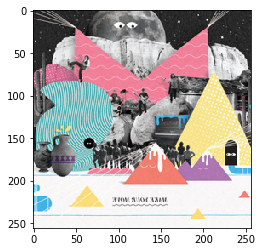

In [72]:
%matplotlib inline
from matplotlib.pyplot import imshow

image = iter(content_loader).next()[0].to(device)
imshow(tensor2im(image))

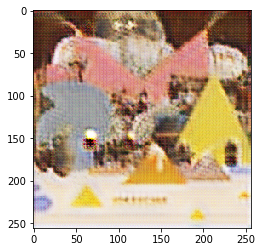

In [73]:
%matplotlib inline
s_image = G(image)
s_i = tensor2im(s_image)
s_i.save('styled.png')
imshow(s_i)

In [13]:
def set_requires_grad(nets, requires_grad=False):
    for net in nets:
        for param in net.parameters():
            param.requires_grad = requires_grad

def gan_criterion(x, target_is_real):
    target = torch.tensor(1.0, device=device) if target_is_real else torch.tensor(0.0, device=device)
    return gan_loss(x, target.expand_as(x))

if torch.cuda.is_available():
    from torch.backends import cudnn
    cudnn.benchmark = True 

#### Train

In [47]:
content_iter, style_iter = iter(content_loader), iter(style_loader)
iter_per_epoch = min(len(content_iter), len(style_iter))

for step in range(TRAIN_ITR + 1):
    if (step + 1) % iter_per_epoch == 0:
        content_iter, style_iter = iter(content_loader), iter(style_loader)
    
    content, style = content_iter.next()[0].to(device), style_iter.next()[0].to(device)
    
    # Generate fakes
    fake_style = G(content)
    fake_content = F(style)
  
    # Reconstruct fakes
    rec_style = F(fake_style)
    rec_content = G(fake_content)
    
    # Train G, F
    set_requires_grad([D_g, D_f], requires_grad=False)
    g_optimizer.zero_grad()
    idt_loss_G = idt_gan_loss(G(style), style) * LAMBDA * 0.5
    idt_loss_F = idt_gan_loss(F(content), content) * LAMBDA * 0.5
    loss_G = gan_criterion(D_g(fake_style), True) * LAMBDA
    loss_F = gan_criterion(D_f(fake_content), True) * LAMBDA
    loss_cyc_style = cycle_loss(rec_style, style)
    loss_cyc_content = cycle_loss(rec_content, content)
    loss_G_F = loss_G + loss_F + loss_cyc_style + loss_cyc_content + idt_loss_G + idt_loss_F
    loss_G_F.backward()
    g_optimizer.step()
  
    # Train D_g, Train D_f
    flip_real_fake = torch.randint(0, 100, (1,)).item() < 0
    set_requires_grad([D_g, D_f], requires_grad=True)
    d_optimizer.zero_grad()
    real_loss_D_g = gan_criterion(D_g(style), flip_real_fake ^ True)
    fake_loss_D_g = gan_criterion(D_g(fake_style.detach()), flip_real_fake ^ False)
    loss_D_g = (real_loss_D_g + fake_loss_D_g) * 0.5
    loss_D_g.backward()
    real_loss_D_f = gan_criterion(D_f(content), flip_real_fake ^ True)
    fake_loss_D_f = gan_criterion(D_f(fake_content.detach()), flip_real_fake ^ False)
    loss_D_f = (real_loss_D_f + fake_loss_D_f) * 0.5
    loss_D_f.backward()
    
    d_optimizer.step()
    
    # Scheduler step
    g_scheduler.step()
    d_scheduler.step()
    
    if (step + 1) % 100 == 0:
        print(f'{step+1: <10}: {loss_G.data.item(): <21} | {loss_F.data.item(): <21} | {loss_G_F.data.item(): <21} | {loss_D_g.data.item(): <21} | {loss_D_f.data.item(): <21}')
        with open('loss.log', 'a+') as f:
            f.write(f'{loss_G.data.item(): <21} | {loss_F.data.item(): <21} | {loss_G_F.data.item(): <21} | {loss_D_g.data.item(): <21} | {loss_D_f.data.item(): <21}\n')
        
    if (step+1) % 10000 == 0:
        print(f'Saving {step+1}...')
        print(f'{loss_G.data.item(): <21} | {loss_F.data.item(): <21} | {loss_G_F.data.item(): <21} | {loss_D_g.data.item(): <21} | {loss_D_f.data.item(): <21}\n')
        G_path = os.path.join('checkpoints', f'G_{step+1}_2.pkl')
        F_path = os.path.join('checkpoints', f'F_{step+1}_2.pkl')
        D_g_path = os.path.join('checkpoints', f'D_g_{step+1}_2.pkl')
        D_f_path = os.path.join('checkpoints', f'D_f_{step+1}_2.pkl')
        torch.save(G.state_dict(), G_path)
        torch.save(F.state_dict(), F_path)
        torch.save(D_g.state_dict(), D_g_path)
        torch.save(D_f.state_dict(), D_f_path)

100       : 2.999612808227539     | 2.565683126449585     | 12.819802284240723    | 0.22070005536079407   | 0.25612157583236694  
200       : 2.516989231109619     | 3.171903133392334     | 12.448348999023438    | 0.22191280126571655   | 0.23088441789150238  
300       : 2.454226493835449     | 2.9406895637512207    | 14.30505657196045     | 0.24106337130069733   | 0.2902143895626068   
400       : 2.9415507316589355    | 3.318223476409912     | 12.92841911315918     | 0.2330484390258789    | 0.21390366554260254  
500       : 3.2744016647338867    | 4.412075042724609     | 14.442913055419922    | 0.1583138406276703    | 0.11598046869039536  
600       : 2.559565305709839     | 6.521954536437988     | 16.21489143371582     | 0.31502383947372437   | 0.09916146099567413  
700       : 1.7885384559631348    | 8.1571683883667       | 18.959636688232422    | 0.28829503059387207   | 0.05256899446249008  
800       : 2.4719655513763428    | 8.95744514465332      | 17.75041961669922     | 0.2901